In [26]:
import gluonts
gluonts.__version__

'0.4.2'

In [27]:
import mxnet
mxnet.__version__

'1.4.1'

In [28]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


In [15]:
dataname = "m4_weekly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


In [16]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_monthly_subset10975_seed42', 'm4_monthly_subset10975_seed43', 'm4_monthly_subset10975_seed44', 'm4_monthly_subset10975_seed45', 'm4_monthly_subset10975_seed46', 'm4_monthly_subset10975_seed47', 'm4_monthly_subset10975_seed48', 'm4_monthly_subset10975_seed49', 'm4_monthly_subset10975_seed50', 'm4_monthly_subset10975_seed51', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 'm4_yearly_finance', 'm4_yearly_industry', 'm4_yearly_

In [17]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [18]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json'), line=1), row=1)}

## Plot Series

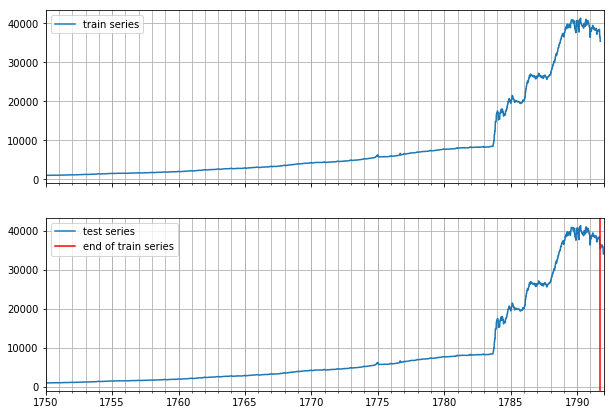

In [19]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [20]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [21]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df


# Yearly

## `Yearly_industry`

...

### Yearly Subsets

## `m4_yearly_demographic`

In [43]:
# change to demographic
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_demographic", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 84123
100%|██████████| 100/100 [00:03<00:00, 31.10it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[0] Elapsed time 3.221 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.893105
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.92it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 2.951 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.386968
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.30it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 3.005 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.132266
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.37it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[3] Elapsed time 2.999 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.989040
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.48it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:02<00:00, 33.56it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[37] Elapsed time 2.993 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.199436
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.90it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[38] Elapsed time 2.954 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.269694
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.27it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[39] Elapsed time 3.011 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.294549
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.36it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[40] Elapsed time 3.095 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.213358
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.23it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[41] Elapsed time 3.107 seconds

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.38it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[111] Elapsed time 3.103 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.982867
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.18it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[112] Elapsed time 3.022 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.970383
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.11it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[113] Elapsed time 3.026 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.963384
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.47it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[114] Elapsed time 2.995 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.933788
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.19it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.52it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[147] Elapsed time 3.080 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.907140
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 30.39it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[148] Elapsed time 3.296 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.957152
INFO:root:Loading parameters from best epoch (138)
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.95it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[149] Elapsed time 3.134 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.914282
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.13it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[150] Elapsed time 3.217 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.888173
INFO:root:Epoch[151] Learning rate is 6.2

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.04it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[183] Elapsed time 3.031 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.902822
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.87it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[184] Elapsed time 3.049 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.896707
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.16it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[185] Elapsed time 3.019 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.930023
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.50it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[186] Elapsed time 3.082 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.870321
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.15it/s, avg_epoch_lo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.684914  0.105629  49.916754            0.112669            0.086625   

   seed  epochs  num_batches  
0    42     200          100  
Seed: 43


100%|██████████| 100/100 [00:03<00:00, 32.60it/s, avg_epoch_loss=7.79]
INFO:root:Epoch[0] Elapsed time 3.076 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.789960
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.87it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[1] Elapsed time 3.252 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.328246
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.43it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 3.188 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.112814
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.51it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[3] Elapsed time 3.181 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.015648
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.32it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[4] Elapsed time 3.199 seconds
INFO:root:E

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.76it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[74] Elapsed time 3.058 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.073154
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.56it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[75] Elapsed time 3.075 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.076937
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.67it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[76] Elapsed time 3.168 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.077256
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.53it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[77] Elapsed time 3.078 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.101624
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.62it/s, avg_epoch_loss=6.04

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.23it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[110] Elapsed time 3.110 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.018619
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.74it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[111] Elapsed time 3.059 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.025792
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.29it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[112] Elapsed time 3.102 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.019291
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.78it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[113] Elapsed time 3.058 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.053095
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.80i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 24.76it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[183] Elapsed time 4.043 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.963526
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.93it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[184] Elapsed time 3.346 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.923034
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.08it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[185] Elapsed time 3.126 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.989001
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.95it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[186] Elapsed time 3.134 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.962129
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.69it/s, avg_epoch_

      MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.69439  0.105805  50.42111            0.113478            0.089172    43   

   epochs  num_batches  
0     200          100  
Seed: 44


100%|██████████| 100/100 [00:03<00:00, 30.36it/s, avg_epoch_loss=7.96]
INFO:root:Epoch[0] Elapsed time 3.297 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.955528
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.43it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[1] Elapsed time 3.188 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.355720
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.31it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 3.005 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.100709
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.78it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[3] Elapsed time 2.969 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.955058
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.50it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[4] Elapsed time 3.083 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:03<00:00, 32.51it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[74] Elapsed time 3.081 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.058663
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.99it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[75] Elapsed time 3.132 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.106538
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.64it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[76] Elapsed time 3.069 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.014573
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 30.07it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[77] Elapsed time 3.331 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.049680
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.63it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[78] Elapsed time 3.072 se

INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.07it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[111] Elapsed time 3.026 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.959317
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.26it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[112] Elapsed time 3.207 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.968708
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.50it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[113] Elapsed time 2.990 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.919115
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.01it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[114] Elapsed time 3.034 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.961611
INFO:root:Epoch[115] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.70it/s, 

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.35it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[147] Elapsed time 3.096 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.900650
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.90it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[148] Elapsed time 3.042 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.899626
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.25it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[149] Elapsed time 3.817 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.931687
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 25.80it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[150] Elapsed time 3.891 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.855547
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 31.27it/

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.913138
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.67it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[183] Elapsed time 3.165 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.932018
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.17it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[184] Elapsed time 3.213 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.932791
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.98it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[185] Elapsed time 3.131 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.892970
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.40it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[186] Elapsed time 3.092 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.910440
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.632419  0.104319  49.195236            0.110587            0.086663   

   seed  epochs  num_batches  
0    44     200          100  
Seed: 45


100%|██████████| 100/100 [00:03<00:00, 31.93it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 3.141 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.056120
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.49it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[1] Elapsed time 2.905 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.362428
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.04it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 3.030 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.181587
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.11it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 3.028 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.974066
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.34it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[4] Elapsed time 3.004 seconds
INFO:root:Ep

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.97it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[74] Elapsed time 3.133 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.066537
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.63it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[75] Elapsed time 3.073 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.048801
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.83it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[76] Elapsed time 3.052 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.040109
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.45it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[77] Elapsed time 3.086 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.039507
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.65it/s, avg_epoch_los

100%|██████████| 100/100 [00:03<00:00, 32.71it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[110] Elapsed time 3.069 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.046550
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.74it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[111] Elapsed time 3.058 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.026731
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.63it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[112] Elapsed time 3.169 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.025249
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.70it/s, avg_epoch_loss=6]
INFO:root:Epoch[113] Elapsed time 3.061 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.000013
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.25it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[114] Ela

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.64it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[183] Elapsed time 3.169 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.030202
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.49it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[184] Elapsed time 3.179 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.971068
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.72it/s, avg_epoch_loss=6]
INFO:root:Epoch[185] Elapsed time 3.156 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.000912
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.51it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[186] Elapsed time 3.081 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.994830
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.74it/s, avg_epoch_los

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.568025  0.104119  44.625814            0.111214            0.083843   

   seed  epochs  num_batches  
0    45     200          100  
Seed: 46


100%|██████████| 100/100 [00:03<00:00, 30.97it/s, avg_epoch_loss=8.09]
INFO:root:Epoch[0] Elapsed time 3.236 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.086308
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.40it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[1] Elapsed time 3.191 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.408519
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.43it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 2.997 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.133817
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.23it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[3] Elapsed time 3.109 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.920473
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.87it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[4] Elapsed time 2.871 seconds
INFO:root:E

100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[74] Elapsed time 3.041 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.025372
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.43it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[75] Elapsed time 2.828 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.057758
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.28it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[76] Elapsed time 3.105 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.083746
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.18it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[77] Elapsed time 2.847 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.073569
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.93it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[78] Elapsed time 3.042 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.75it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[111] Elapsed time 2.725 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.992745
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.20it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[112] Elapsed time 2.628 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.958050
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.22it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[113] Elapsed time 3.015 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.886508
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.45it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[114] Elapsed time 2.746 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.962553
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.70it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[147] Elapsed time 2.984 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.875890
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.56it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[148] Elapsed time 2.664 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.927425
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.62it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[149] Elapsed time 2.664 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.892023
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.06it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[150] Elapsed time 2.633 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.869686
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.77i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.62it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[183] Elapsed time 2.980 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.878471
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.61it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[184] Elapsed time 2.979 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.876194
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.54it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[185] Elapsed time 2.671 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.867374
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.05it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[186] Elapsed time 3.124 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.914014
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.60it/s, avg_epoch_

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.650574  0.10435  49.622659            0.112441            0.085469    46   

   epochs  num_batches  
0     200          100  
Seed: 47


100%|██████████| 100/100 [00:02<00:00, 35.11it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 2.854 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.262423
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.07it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 2.939 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.292288
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.37it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[2] Elapsed time 3.005 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.035471
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.87it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[3] Elapsed time 3.050 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.927566
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.01it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[4] Elapsed time 3.035 seconds
INFO:root:E

100%|██████████| 100/100 [00:03<00:00, 32.71it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[74] Elapsed time 3.058 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.082447
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.93it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[75] Elapsed time 3.044 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.107151
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.89it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[76] Elapsed time 3.047 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.047825
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.87it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[77] Elapsed time 3.048 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.078162
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.17it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[78] Elapsed time 2.933 second

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.901394
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.72it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[111] Elapsed time 3.157 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.934475
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.74it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[112] Elapsed time 3.061 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.925168
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.38it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[113] Elapsed time 3.094 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.911792
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 28.06it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[114] Elapsed time 3.569 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.901241
INFO:root:Epoch[115] Learning rate i

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.855548
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.26it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[183] Elapsed time 3.013 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.874299
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.34it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[184] Elapsed time 3.100 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.867208
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.94it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[185] Elapsed time 3.136 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.876541
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.32it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[186] Elapsed time 3.101 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.900537
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.620487  0.104153  45.963026             0.11075            0.083592   

   seed  epochs  num_batches  
0    47     200          100  
Seed: 48


100%|██████████| 100/100 [00:03<00:00, 31.80it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[0] Elapsed time 3.151 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.006199
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.51it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[1] Elapsed time 3.080 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.423411
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.49it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 3.083 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.222956
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.64it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[3] Elapsed time 3.068 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.013650
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.76it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[4] Elapsed time 2.966 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 33.84it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[74] Elapsed time 2.961 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.108599
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.07it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[75] Elapsed time 3.027 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.097392
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.30it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[76] Elapsed time 3.103 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.047289
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.24it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[77] Elapsed time 3.012 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.109024
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.90it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[78] Elapsed time 3.047 seconds

100%|██████████| 100/100 [00:03<00:00, 32.69it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[111] Elapsed time 3.065 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.991226
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.68it/s, avg_epoch_loss=6]
INFO:root:Epoch[112] Elapsed time 3.068 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.998381
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.93it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[113] Elapsed time 3.045 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.031386
INFO:root:Loading parameters from best epoch (103)
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.40it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[114] Elapsed time 3.091 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.027179
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.91it/s, avg_

100%|██████████| 100/100 [00:03<00:00, 32.07it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[147] Elapsed time 3.126 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.859160
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.72it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[148] Elapsed time 3.062 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.892982
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.81it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[149] Elapsed time 3.150 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.906313
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.80it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[150] Elapsed time 3.148 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.912214
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 30.90it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[151] Elap

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.673549  0.106886  49.994311            0.113987            0.087196   

   seed  epochs  num_batches  
0    48     200          100  
Seed: 49


100%|██████████| 100/100 [00:03<00:00, 30.85it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[0] Elapsed time 3.250 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.934427
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.21it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[1] Elapsed time 3.317 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.405888
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.04it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[2] Elapsed time 3.031 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.138430
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.47it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 3.083 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.944525
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.03it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[4] Elapsed time 3.030 seconds
INFO:root:E

100%|██████████| 100/100 [00:03<00:00, 32.48it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[74] Elapsed time 3.085 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.054635
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.05it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[75] Elapsed time 3.127 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.164869
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.95it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[76] Elapsed time 3.237 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.029951
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.81it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[77] Elapsed time 3.147 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.147129
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.61it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[78] Elapsed time 3.168 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.58it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[111] Elapsed time 3.171 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.994135
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.28it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[112] Elapsed time 3.103 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.954397
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.93it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[113] Elapsed time 3.040 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.950898
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 30.93it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[114] Elapsed time 3.240 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.942556
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.47it/s, avg_e

100%|██████████| 100/100 [00:03<00:00, 31.18it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[147] Elapsed time 3.211 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.932737
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.79it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[148] Elapsed time 3.152 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.949873
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.43it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[149] Elapsed time 3.087 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.905221
INFO:root:Loading parameters from best epoch (139)
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.49it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[150] Elapsed time 3.083 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.894922
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 31.6

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.33it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[183] Elapsed time 3.098 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.871591
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.69it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[184] Elapsed time 3.160 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.903479
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.28it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[185] Elapsed time 3.203 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.881292
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.92it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[186] Elapsed time 3.137 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.890406
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.11it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.614157  0.104375  47.640556            0.111183            0.085443   

   seed  epochs  num_batches  
0    49     200          100  
Seed: 50


100%|██████████| 100/100 [00:03<00:00, 31.36it/s, avg_epoch_loss=7.85]
INFO:root:Epoch[0] Elapsed time 3.201 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.845539
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.73it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 3.057 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.437105
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.87it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 3.049 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.212604
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.18it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[3] Elapsed time 3.213 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.071288
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.28it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[4] Elapsed time 3.200 seconds
INFO:root:E

100%|██████████| 100/100 [00:03<00:00, 32.62it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[74] Elapsed time 3.073 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.012962
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.80it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[75] Elapsed time 3.055 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.092681
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.76it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[76] Elapsed time 2.969 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.041119
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[77] Elapsed time 2.982 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.093705
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.77it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[78] Elapsed time 3.155 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.67it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[111] Elapsed time 2.976 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.982142
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.66it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[112] Elapsed time 3.163 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.981598
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.90it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[113] Elapsed time 3.044 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.894256
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.98it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[114] Elapsed time 3.036 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.918087
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.22it/s, avg_e

100%|██████████| 100/100 [00:02<00:00, 33.88it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[147] Elapsed time 2.959 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.888266
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.18it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[148] Elapsed time 3.019 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.851097
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.12it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[149] Elapsed time 3.025 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.871021
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.72it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[150] Elapsed time 3.062 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.880466
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.83it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.04it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[183] Elapsed time 3.126 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.848748
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.80it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[184] Elapsed time 3.053 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.827472
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 24.88it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[185] Elapsed time 4.026 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.855843
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.89it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[186] Elapsed time 3.141 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.836891
INFO:root:Loading parameters from best epoch (176)
INFO:root:Epoch[187] Learning rate is 5e-

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.692234  0.107564  51.279997            0.113612            0.089908   

   seed  epochs  num_batches  
0    50     200          100  
Seed: 51


100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=8.07]
INFO:root:Epoch[0] Elapsed time 3.043 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.069426
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.84it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 3.247 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.386609
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.01it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[2] Elapsed time 3.035 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.171026
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.24it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 3.013 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.978902
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.70it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[4] Elapsed time 3.064 seconds
INFO:root:E

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.141205
INFO:root:Loading parameters from best epoch (63)
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.84it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[74] Elapsed time 3.056 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.112846
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.62it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[75] Elapsed time 3.083 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.058647
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.11it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[76] Elapsed time 3.120 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.062458
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.95it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[77] Elapsed time 3.042 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.0

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.114250
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.28it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[110] Elapsed time 3.010 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.113876
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.69it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[111] Elapsed time 3.066 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.068105
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.74it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[112] Elapsed time 3.156 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.082083
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.08it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[113] Elapsed time 2.944 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.077130
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.05it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[183] Elapsed time 3.226 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.022511
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.80it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[184] Elapsed time 3.054 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.085817
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.25it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[185] Elapsed time 3.204 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.036202
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.84it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[186] Elapsed time 3.052 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.036665
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.54it/s, avg_epoch_

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.593641  0.10337  46.849017            0.110556            0.082464    51   

   epochs  num_batches  
0     200          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,2.684914,0.105629,49.916754,0.112669,0.086625,42,200,100
0,2.694390,0.105805,50.421110,0.113478,0.089172,43,200,100
0,2.632419,0.104319,49.195236,0.110587,0.086663,44,200,100
0,2.568025,0.104119,44.625814,0.111214,0.083843,45,200,100
0,2.650574,0.104350,49.622659,0.112441,0.085469,46,200,100
0,2.620487,0.104153,45.963026,0.110750,0.083592,47,200,100
0,2.673549,0.106886,49.994311,0.113987,0.087196,48,200,100
0,2.614157,0.104375,47.640556,0.111183,0.085443,49,200,100
0,2.692234,0.107564,51.279997,0.113612,0.089908,50,200,100
0,2.593641,0.103370,46.849017,0.110556,0.082464,51,200,100


## `m4_yearly_other`